### Libraries & Environment Setup

Import required libraries, helper functions, and configure display options (e.g., suppress warnings) for the analysis.

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from utils import load_data, EventRolling, EventRollingConfig
warnings.filterwarnings("ignore")

### Load Dataset

Load data with `load_data()` and perform an initial inspection (head, columns, info) to verify structure and completeness.

In [2]:
df = load_data()

In [3]:
df.head()

,date,fed_funds,fomc_event,fomc_Labor Market Conditions,fomc_Inflation and Inflation Expectations,fomc_Economic Activity,fomc_Financial Conditions,fomc_Global Economic Developments,fomc_Monetary Policy Stance,fomc_Risks and Uncertainties,...,log_Bid_Spot_usd_cny,delta_log_Bid_Spot_usd_cny,log_Ask_Spot_usd_cny,delta_log_Ask_Spot_usd_cny,Bid_Spot_eur_usd,Ask_Spot_eur_usd,log_Bid_Spot_eur_usd,delta_log_Bid_Spot_eur_usd,log_Ask_Spot_eur_usd,delta_log_Ask_Spot_eur_usd
0,2019-01-01,2.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.927964,NaN,1.928837,NaN,1.1462,1.1466,0.136452,NaN,0.136801,NaN
1,2019-01-02,2.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.925664,-0.002301,1.926334,-0.002503,1.1342,1.1345,0.125928,-0.010525,0.126192,-0.010609
2,2019-01-03,2.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.927281,0.001617,1.927644,0.001310,1.1392,1.1396,0.130326,0.004399,0.130677,0.004485
3,2019-01-04,2.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.926625,-0.000655,1.927470,-0.000175,1.1393,1.1397,0.130414,0.000088,0.130765,0.000088
4,2019-01-07,2.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.924263,-0.002362,1.924526,-0.002944,1.1474,1.1477,0.137499,0.007084,0.137760,0.006995


In [4]:
df.columns

Index(['date', 'fed_funds', 'fomc_event', 'fomc_Labor Market Conditions',
       'fomc_Inflation and Inflation Expectations', 'fomc_Economic Activity',
       'fomc_Financial Conditions', 'fomc_Global Economic Developments',
       'fomc_Monetary Policy Stance', 'fomc_Risks and Uncertainties',
       ...
       'log_Bid_Spot_usd_cny', 'delta_log_Bid_Spot_usd_cny',
       'log_Ask_Spot_usd_cny', 'delta_log_Ask_Spot_usd_cny',
       'Bid_Spot_eur_usd', 'Ask_Spot_eur_usd', 'log_Bid_Spot_eur_usd',
       'delta_log_Bid_Spot_eur_usd', 'log_Ask_Spot_eur_usd',
       'delta_log_Ask_Spot_eur_usd'],
      dtype='object', length=120)

In [5]:
df[['Bid_FW_usd_vnd_1y', 'Bid_FW_usd_cny_1y']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Bid_FW_usd_vnd_1y  1816 non-null   float64
 1   Bid_FW_usd_cny_1y  1816 non-null   float64
dtypes: float64(2)
memory usage: 28.5 KB


### Data Overview & Visualization

Normalize and plot the USD/VND and USD/CNY 1-year forward rates, and plot the Federal Funds Rate time series for visual inspection.

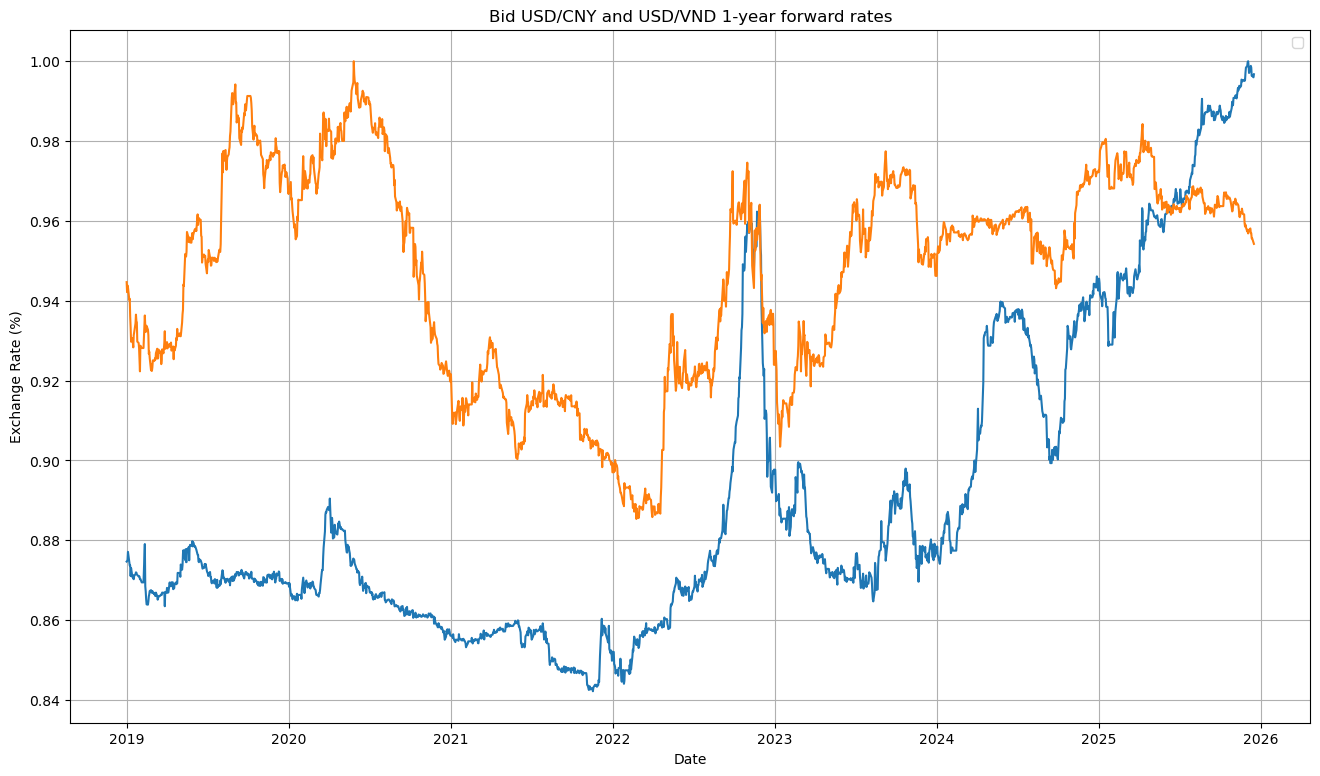

In [6]:
dates = pd.to_datetime(df['date'])
y = df[['Bid_FW_usd_vnd_1y', 'Bid_FW_usd_cny_1y']]
for col in y.columns:
    y[col] = y[col] / y[col].abs().max()    
plt.figure(figsize=(16, 9))
plt.plot(dates, y, alpha=1)
plt.xlabel('Date')
plt.ylabel('Exchange Rate (%)')
plt.legend()
plt.title('Bid USD/CNY and USD/VND 1-year forward rates')
plt.grid(visible=True)
plt.show()

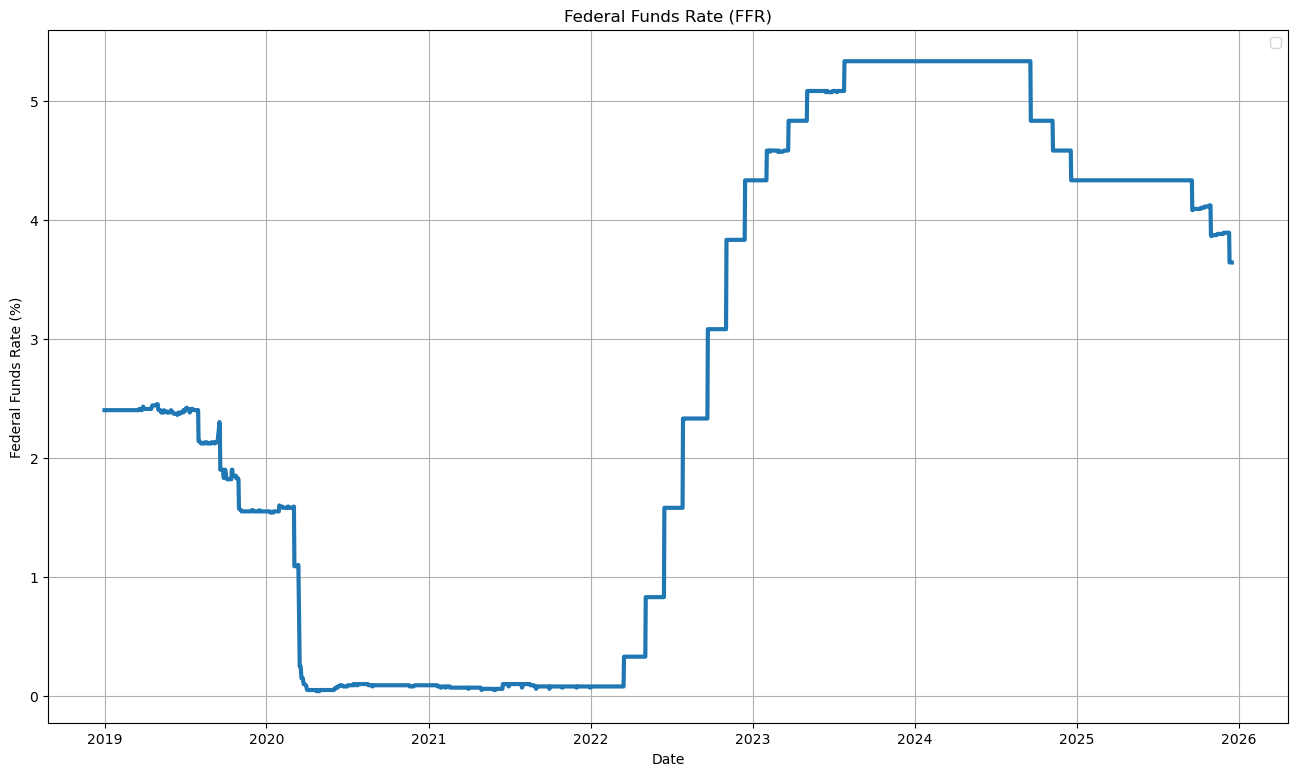

In [7]:
dates = pd.to_datetime(df['date'])
y = df['fed_funds']
plt.figure(figsize=(16, 9))
plt.plot(dates, y, linewidth=3)
plt.xlabel('Date')
plt.ylabel('Federal Funds Rate (%)')
plt.legend()
plt.title('Federal Funds Rate (FFR)')
plt.grid(visible=True)
plt.show()

### Effects of Fed Policy and FOMC Communication on USD/VND

Prepare USD/VND data, configure rolling event regressions, run the asymmetric rolling regression, and display summary statistics (including mean R-squared).

In [8]:
merged_df_vnd = df.copy()

In [9]:
y_vars = ["Bid_FW_usd_vnd_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=21,
    days_after=21,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=merged_df_vnd,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_vnd = analyzer.rolling_event_regression_asymmetric()
summary_df_vnd = analyzer.summarize_results(results_df_vnd)
r_squared_mean = round(results_df_vnd['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_vnd)

R_Squared: 0.52237


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,51,54,0.944,2908.572580,0.000456,27894.766090,2020-01-03
1,fomc_Inflation and Inflation Expectations,51,54,0.944,-600.705494,0.000023,26832.919377,2019-07-10
5,fomc_Monetary Policy Stance,50,54,0.926,-947.376870,0.000008,20632.297277,2019-11-20
6,fomc_Risks and Uncertainties,50,54,0.926,1015.752831,0.000073,11943.676103,2023-07-05
2,fomc_Economic Activity,48,54,0.889,1659.308401,0.000019,22599.724408,2020-01-03
3,fomc_Financial Conditions,48,54,0.889,54.314077,0.001091,12122.411914,2019-07-10
7,fomc_action_dummy,47,54,0.870,7160.647777,0.001129,14564.350919,2019-10-09
4,fomc_Global Economic Developments,36,54,0.667,150.819133,0.000054,9298.255363,2020-01-03
8,fed_funds_t,31,54,0.574,1142.848486,0.002264,4977.672762,2025-07-09


In [10]:
results_df_vnd.head()

,event_index,event_date,r_squared,beta_fomc_Labor Market Conditions,pval_fomc_Labor Market Conditions,significant_fomc_Labor Market Conditions,beta_fomc_Inflation and Inflation Expectations,pval_fomc_Inflation and Inflation Expectations,significant_fomc_Inflation and Inflation Expectations,beta_fomc_Economic Activity,...,significant_fomc_Monetary Policy Stance,beta_fomc_Risks and Uncertainties,pval_fomc_Risks and Uncertainties,significant_fomc_Risks and Uncertainties,beta_fomc_action_dummy,pval_fomc_action_dummy,significant_fomc_action_dummy,beta_fed_funds_t,pval_fed_funds_t,significant_fed_funds_t
0,36,2019-02-20,0.001676,2107.296053,4.301189e-119,True,-1053.648026,4.301189e-119,True,1580.472039,...,True,-526.824013,4.301189e-119,True,10536.480263,4.301189e-119,True,-222.500000,0.604819,False
1,71,2019-04-10,0.585128,2020.380758,1.779933e-38,True,-1687.991279,2.342489e-36,True,-405.150315,...,True,285.672527,2.734650e-25,True,12361.240124,1.648985e-37,True,-1384.663488,0.110752,False
2,101,2019-05-22,0.466075,1922.657656,1.279084e-156,True,-1970.712518,1.992327e-197,True,-1089.552325,...,True,640.885885,1.279084e-156,True,12817.717708,1.279084e-156,True,-1868.828680,0.000021,True
3,136,2019-07-10,0.731467,20124.689532,2.553068e-24,True,-26832.919377,2.553068e-24,True,13416.459688,...,True,6708.229844,2.553068e-24,True,21.172767,9.517322e-01,False,-250.316717,0.843504,False
4,166,2019-08-21,0.455621,18187.470186,0.000000e+00,True,-25852.471962,0.000000e+00,True,12124.980124,...,True,9267.513489,0.000000e+00,True,-46.943984,5.054043e-02,False,15.246312,0.854624,False


### Count Significant Events

Use `count_significant_events` to identify how many events have at least one statistically significant beta coefficient.

In [11]:
def count_significant_events(
    df,
    sig_prefix="significant_",
    count_col="significant_beta_count",
    event_flag_col="is_event_significant",
    verbose=True
):
    """
    Count the number of events that have at least one statistically significant beta.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing regression results (e.g., results_df_vnd, results_df_cny)

    sig_prefix : str, default="significant_"
        Prefix of columns that indicate statistical significance

    count_col : str
        Name of the column storing the number of significant betas per event

    event_flag_col : str
        Name of the column indicating whether an event is significant or not

    verbose : bool
        Print results to the console if True

    Returns
    -------
    dict
        {
            "n_significant": number of significant events,
            "n_total": total number of events,
            "ratio": proportion of significant events,
            "df": DataFrame with added columns
        }
    """

    sig_cols = [c for c in df.columns if c.startswith(sig_prefix)]

    if len(sig_cols) == 0:
        raise ValueError("No significance columns were found.")

    df[count_col] = df[sig_cols].sum(axis=1)

    df[event_flag_col] = df[count_col] > 0

    n_significant = df[event_flag_col].sum()
    n_total = len(df)
    ratio = n_significant / n_total if n_total > 0 else 0

    if verbose:
        print(
            f"There are {n_significant}/{n_total} significant events "
            f"({ratio:.2%})"
        )

    return {
        "n_significant": n_significant,
        "n_total": n_total,
        "ratio": ratio,
        "df": df
    }


In [12]:
vnd_stats = count_significant_events(results_df_vnd)

There are 51/54 significant events (94.44%)


#### Create Statistical Summary for Significant Events

Select beta and p-value columns and construct descriptive statistics for events flagged as significant.

In [13]:
beta_pval_cols_vnd = results_df_vnd.columns[['beta' in col or 'pval' in col for col in results_df_vnd.columns]]
beta_pval_cols_vnd

Index(['beta_fomc_Labor Market Conditions',
       'pval_fomc_Labor Market Conditions',
       'beta_fomc_Inflation and Inflation Expectations',
       'pval_fomc_Inflation and Inflation Expectations',
       'beta_fomc_Economic Activity', 'pval_fomc_Economic Activity',
       'beta_fomc_Financial Conditions', 'pval_fomc_Financial Conditions',
       'beta_fomc_Global Economic Developments',
       'pval_fomc_Global Economic Developments',
       'beta_fomc_Monetary Policy Stance', 'pval_fomc_Monetary Policy Stance',
       'beta_fomc_Risks and Uncertainties',
       'pval_fomc_Risks and Uncertainties', 'beta_fomc_action_dummy',
       'pval_fomc_action_dummy', 'beta_fed_funds_t', 'pval_fed_funds_t',
       'significant_beta_count'],
      dtype='object')

In [14]:
significant_event_vnd = results_df_vnd[['event_date', "is_event_significant"]]
significant_event_vnd['fomc_change'] = merged_df_vnd['fomc_change'].dropna().tolist()
for col in beta_pval_cols_vnd:
    significant_event_vnd[col] = results_df_vnd[col]

In [15]:
significant_event_vnd.head()

,event_date,is_event_significant,fomc_change,beta_fomc_Labor Market Conditions,pval_fomc_Labor Market Conditions,beta_fomc_Inflation and Inflation Expectations,pval_fomc_Inflation and Inflation Expectations,beta_fomc_Economic Activity,pval_fomc_Economic Activity,beta_fomc_Financial Conditions,...,pval_fomc_Global Economic Developments,beta_fomc_Monetary Policy Stance,pval_fomc_Monetary Policy Stance,beta_fomc_Risks and Uncertainties,pval_fomc_Risks and Uncertainties,beta_fomc_action_dummy,pval_fomc_action_dummy,beta_fed_funds_t,pval_fed_funds_t,significant_beta_count
0,2019-02-20,True,maintain,2107.296053,4.301189e-119,-1053.648026,4.301189e-119,1580.472039,4.301189e-119,-1580.472039,...,4.301189e-119,-2107.296053,4.301189e-119,-526.824013,4.301189e-119,10536.480263,4.301189e-119,-222.500000,0.604819,8
1,2019-04-10,True,maintain,2020.380758,1.779933e-38,-1687.991279,2.342489e-36,-405.150315,9.238201e-19,-498.584219,...,2.734650e-25,-2472.248025,1.648985e-37,285.672527,2.734650e-25,12361.240124,1.648985e-37,-1384.663488,0.110752,8
2,2019-05-22,True,maintain,1922.657656,1.279084e-156,-1970.712518,1.992327e-197,-1089.552325,1.500589e-35,0.000000,...,1.279084e-156,-2611.598403,5.856755e-187,640.885885,1.279084e-156,12817.717708,1.279084e-156,-1868.828680,0.000021,8
3,2019-07-10,True,maintain,20124.689532,2.553068e-24,-26832.919377,2.553068e-24,13416.459688,2.553068e-24,-12122.411914,...,1.316558e-20,-9296.325393,4.190651e-30,6708.229844,2.553068e-24,21.172767,9.517322e-01,-250.316717,0.843504,7
4,2019-08-21,True,decrease,18187.470186,0.000000e+00,-25852.471962,0.000000e+00,12124.980124,0.000000e+00,-4459.978348,...,NaN,-13379.935045,0.000000e+00,9267.513489,0.000000e+00,-46.943984,5.054043e-02,15.246312,0.854624,6


#### Map FOMC Messages to Significant Events

Group significant events by `fomc_change` to identify which communication messages are associated with statistically significant effects.

In [16]:
significant_event_vnd[significant_event_vnd['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,37


In [17]:
table_4_1_vnd = significant_event_vnd[significant_event_vnd['pval_fed_funds_t'] < 0.05].groupby('fomc_change').describe()[['beta_fed_funds_t']]
table_4_1_vnd

beta_fed_funds_t                                        \
                       count         mean          min         25%   
fomc_change                                                          
decrease                 1.0  -110.570632  -110.570632 -110.570632   
increase                 7.0  -183.548939  -897.284324 -503.897787   
maintain                23.0  1601.031142 -4150.859805 -284.693188   

                                                                 
                     50%          75%          max          std  
fomc_change                                                      
decrease     -110.570632  -110.570632  -110.570632          NaN  
increase     -150.482655    97.487956   575.744072   493.016424  
maintain     1786.107095  4088.744289  4977.672762  2902.766103

### Effects of Fed Policy and FOMC Communication on USD/CNY

Repeat the rolling event regression analysis for USD/CNY and present a summary of results.

In [18]:
merged_df_cny = df.copy()

In [19]:
y_vars = ["Bid_FW_usd_cny_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=21,
    days_after=21,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=merged_df_cny,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_cny = analyzer.rolling_event_regression_asymmetric()
summary_df_cny = analyzer.summarize_results(results_df_cny)
r_squared_mean = round(results_df_cny['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_cny)

R_Squared: 0.47696


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,49,54,0.907,0.842743,9.429569e-06,6.850188,2019-07-10
5,fomc_Monetary Policy Stance,49,54,0.907,-0.343727,1.086958e-03,5.937686,2019-11-20
1,fomc_Inflation and Inflation Expectations,48,54,0.889,-0.275465,4.039844e-07,9.133585,2019-07-10
2,fomc_Economic Activity,48,54,0.889,0.465734,1.164666e-06,5.532140,2020-01-03
6,fomc_Risks and Uncertainties,47,54,0.870,0.321106,1.806727e-04,3.208248,2023-07-05
7,fomc_action_dummy,46,54,0.852,2.109332,5.345585e-06,5.170886,2019-05-22
3,fomc_Financial Conditions,44,54,0.815,-0.065850,1.439787e-04,4.166679,2019-07-10
4,fomc_Global Economic Developments,36,54,0.667,0.015905,4.824290e-04,2.282846,2020-01-03
8,fed_funds_t,26,54,0.481,0.653291,3.337185e-03,2.906688,2021-04-07


#### Count Significant Events (USD/CNY)

Compute the number and fraction of events with at least one significant beta for USD/CNY.

In [20]:
cny_stats = count_significant_events(results_df_cny)

There are 51/54 significant events (94.44%)


#### Create Statistical Summary (USD/CNY)

Generate descriptive statistics for significant beta estimates grouped by `fomc_change`.

In [21]:
beta_pval_cols_cny = results_df_cny.columns[['pval' in col or 'beta' in col for col in results_df_cny.columns]]
beta_pval_cols_cny

Index(['beta_fomc_Labor Market Conditions',
       'pval_fomc_Labor Market Conditions',
       'beta_fomc_Inflation and Inflation Expectations',
       'pval_fomc_Inflation and Inflation Expectations',
       'beta_fomc_Economic Activity', 'pval_fomc_Economic Activity',
       'beta_fomc_Financial Conditions', 'pval_fomc_Financial Conditions',
       'beta_fomc_Global Economic Developments',
       'pval_fomc_Global Economic Developments',
       'beta_fomc_Monetary Policy Stance', 'pval_fomc_Monetary Policy Stance',
       'beta_fomc_Risks and Uncertainties',
       'pval_fomc_Risks and Uncertainties', 'beta_fomc_action_dummy',
       'pval_fomc_action_dummy', 'beta_fed_funds_t', 'pval_fed_funds_t',
       'significant_beta_count'],
      dtype='object')

In [22]:
significant_event_cny = results_df_cny[['event_date', "is_event_significant"]]
significant_event_cny['fomc_change'] = merged_df_cny['fomc_change'].dropna().tolist()
for col in beta_pval_cols_cny:
    significant_event_cny[col] = results_df_cny[col]

In [23]:
significant_event_cny.head()

,event_date,is_event_significant,fomc_change,beta_fomc_Labor Market Conditions,pval_fomc_Labor Market Conditions,beta_fomc_Inflation and Inflation Expectations,pval_fomc_Inflation and Inflation Expectations,beta_fomc_Economic Activity,pval_fomc_Economic Activity,beta_fomc_Financial Conditions,...,pval_fomc_Global Economic Developments,beta_fomc_Monetary Policy Stance,pval_fomc_Monetary Policy Stance,beta_fomc_Risks and Uncertainties,pval_fomc_Risks and Uncertainties,beta_fomc_action_dummy,pval_fomc_action_dummy,beta_fed_funds_t,pval_fed_funds_t,significant_beta_count
0,2019-02-20,True,maintain,0.739340,1.136878e-08,-0.369670,1.136878e-08,0.554505,1.136878e-08,-0.554505,...,1.136878e-08,-0.739340,1.136878e-08,-0.184835,1.136878e-08,3.696700,1.136878e-08,-0.717500,2.430790e-01,8
1,2019-04-10,True,maintain,0.607511,1.570345e-17,-0.504495,2.832507e-16,-0.113128,1.060873e-07,-0.154524,...,1.282848e-10,-0.741337,6.011269e-17,0.082318,1.282848e-10,3.706686,6.011269e-17,-0.551647,1.658609e-01,8
2,2019-05-22,True,maintain,0.775633,3.438196e-73,-0.823255,4.862874e-124,-0.326599,5.672559e-07,0.000000,...,3.438196e-73,-1.081800,2.965055e-108,0.258544,3.438196e-73,5.170886,3.438196e-73,-1.891368,2.206098e-13,8
3,2019-07-10,True,maintain,6.850188,5.650437e-09,-9.133585,5.650437e-09,4.566792,5.650437e-09,-4.166679,...,4.995592e-08,-3.083623,2.136720e-10,2.283396,5.650437e-09,0.008906,9.654874e-01,-0.551208,4.624549e-01,7
4,2019-08-21,True,decrease,5.938682,3.817981e-66,-8.379194,4.162563e-66,3.959121,3.817981e-66,-1.518610,...,NaN,-4.555830,2.582317e-65,2.901462,3.861797e-65,-0.078221,2.500656e-01,-0.286582,2.376582e-01,6


In [24]:
table_4_1_cny = significant_event_cny[significant_event_cny['pval_fed_funds_t'] < 0.05].groupby('fomc_change').describe()[['beta_fed_funds_t']]
table_4_1_cny

beta_fed_funds_t                                          \
                       count      mean       min       25%       50%   
fomc_change                                                            
decrease                 1.0  0.163187  0.163187  0.163187  0.163187   
increase                 4.0  0.014353 -0.119062 -0.043533  0.025209   
maintain                21.0  0.798332 -1.891368  0.114668  1.111557   

                                           
                  75%       max       std  
fomc_change                                
decrease     0.163187  0.163187       NaN  
increase     0.083095  0.126058  0.106941  
maintain     1.325539  2.906688  0.952668

#### Map FOMC Messages to Significant Events (USD/CNY)

Identify which FOMC communication types are most frequently associated with significant effects in USD/CNY regressions.

In [25]:
significant_event_cny[significant_event_cny['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,37


### USD/VND Shows Stronger Responses to Fed Action Than USD/CNY

Normalize and compare beta coefficients on Fed action between USD/VND and USD/CNY to highlight relative differences over time.

In [26]:
beta_fed_funds_vnd = results_df_vnd['beta_fed_funds_t'] / results_df_vnd['beta_fed_funds_t'].abs().max()
beta_fed_funds_cny = results_df_cny['beta_fed_funds_t'] / results_df_cny['beta_fed_funds_t'].abs().max()

In [27]:
beta_fed_funds_vnd_cny = pd.DataFrame({
    "event_date": results_df_vnd['event_date'],
    "beta_fed_funds_vnd": beta_fed_funds_vnd,
    "beta_fed_funds_cny": beta_fed_funds_cny
    })

In [28]:
beta_fed_funds_vnd_cny.head()

,event_date,beta_fed_funds_vnd,beta_fed_funds_cny
0,2019-02-20,-0.026490,-0.246845
1,2019-04-10,-0.164851,-0.189785
2,2019-05-22,-0.222493,-0.650695
3,2019-07-10,-0.029801,-0.189635
4,2019-08-21,0.001815,-0.098594


In [29]:
def plot_usdvnd_fed_action_with_tightening(
    df: pd.DataFrame,
    tightening_periods: list,
    beta_col: str = "beta_fed_funds_vnd",
    title: str = "Fed action matters more for USD/VND during monetary tightening"
):
    """
    Parameters
    ----------
    df : DataFrame
        Must contain the following columns:
        - event_date
        - beta_fed_funds_vnd (or another beta column passed via beta_col)

    tightening_periods : list of tuples
        [(start_date, end_date), ...]
        date format: 'YYYY-MM-DD'
    """

    dates = pd.to_datetime(df["event_date"])
    beta = df[beta_col]

    fig, ax = plt.subplots(figsize=(14, 6))

    for start, end in tightening_periods:
        color = "gray"
        if start == "2022-02-01":
            color = "red"
        ax.axvspan(
            pd.to_datetime(start),
            pd.to_datetime(end),
            color=color,
            alpha=0.18,
            zorder=0
        )

    ax.plot(
        dates,
        beta,
        marker="o",
        linewidth=2,
        label=["β Fed action (USD/VND)", "β Fed action (USD/CNY)"],
        zorder=2
    )

    ax.axhline(0, color="black", linestyle="--", linewidth=1)

    ax.xaxis.set_major_locator(
        mdates.MonthLocator(bymonth=[1, 4, 7, 10])
    )

    def month_year_formatter(x, pos):
        dt = mdates.num2date(x)
        if dt.month == 1:
            return f"{dt.year}"
        elif dt.month == 4:
            return "Apr"
        elif dt.month == 7:
            return "Jul"
        elif dt.month == 10:
            return "Oct"
        return ""

    ax.xaxis.set_major_formatter(
        plt.FuncFormatter(month_year_formatter)
    )

    ax.set_xlabel("Calendar Time")
    ax.set_ylabel("β Fed Funds Rate")

    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


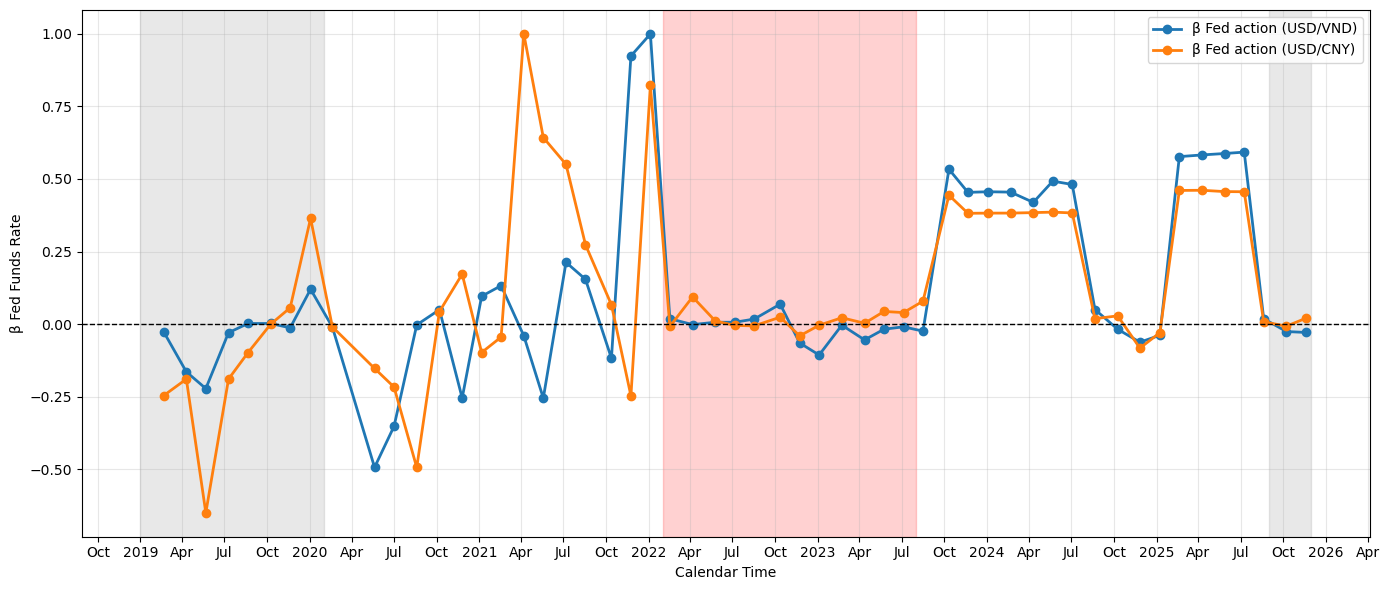

In [30]:
tightening_periods = [
    ("2019-01-01", "2020-02-01"),
    ("2022-02-01", "2023-08-01"),
    ("2025-09-01", "2025-12-01"),
]

plot_usdvnd_fed_action_with_tightening(
    df=beta_fed_funds_vnd_cny,
    tightening_periods=tightening_periods,
    beta_col= ['beta_fed_funds_vnd', 'beta_fed_funds_cny']
)

### Broad USD/VND Responses vs Selective USD/CNY Responses to Fed Communication

Plot time-varying betas for each FOMC communication component for both currencies; mark statistically significant points in red.

In [31]:
def plot_fed_communication_figure(
    results_df_vnd: pd.DataFrame,
    results_df_cny: pd.DataFrame,
):
    """
    Figure: Time-varying effects of Fed communication components
    - 7 panels
    - Dual y-axis: USD/VND (left) vs USD/CNY (right)
    - Red markers = statistically significant
    """

    fed_components = [
        "fomc_Labor Market Conditions",
        "fomc_Inflation and Inflation Expectations",
        "fomc_Economic Activity",
        "fomc_Financial Conditions",
        "fomc_Global Economic Developments",
        "fomc_Monetary Policy Stance",
        "fomc_Risks and Uncertainties"
    ]

    dates = pd.to_datetime(results_df_vnd["event_date"])

    fig, axes = plt.subplots(
        nrows=len(fed_components),
        ncols=1,
        figsize=(14, 14),
        sharex=True
    )

    for i, comp in enumerate(fed_components):
        ax_left = axes[i]
        ax_right = ax_left.twinx()

        beta_vnd = results_df_vnd[f"beta_{comp}"]
        beta_cny = results_df_cny[f"beta_{comp}"]

        sig_vnd = results_df_vnd[f"significant_{comp}"]
        sig_cny = results_df_cny[f"significant_{comp}"]

        ax_left.plot(
            dates,
            beta_vnd,
            color="tab:blue",
            linewidth=1.5,
            label="USD/VND"
        )
        ax_left.scatter(
            dates[sig_vnd],
            beta_vnd[sig_vnd],
            color="red",
            s=18,
            zorder=3
        )

        ax_left.axhline(0, linestyle="--", linewidth=1)
        ax_left.grid(True, alpha=0.3)
        if i == 3:
            ax_left.set_ylabel("β (USD/VND)", fontsize=9)

        ax_right.plot(
            dates,
            beta_cny,
            color="tab:orange",
            linewidth=1.5,
            linestyle="--",
            label="USD/CNY"
        )
        ax_right.scatter(
            dates[sig_cny],
            beta_cny[sig_cny],
            color="red",
            s=18,
            zorder=3
        )
        if i == 3:
            ax_right.set_ylabel("β (USD/CNY)", fontsize=9)

        ax_left.set_title(
            comp.replace("fomc_", ""),
            fontsize=10,
            loc="left"
        )

        if i == 0:
            lines_l, labels_l = ax_left.get_legend_handles_labels()
            lines_r, labels_r = ax_right.get_legend_handles_labels()
            ax_left.legend(
                lines_l + lines_r,
                labels_l + labels_r,
                loc="upper right",
                fontsize=9
            )

    axes[-1].set_xlabel("Date")
    plt.tight_layout()
    plt.show()


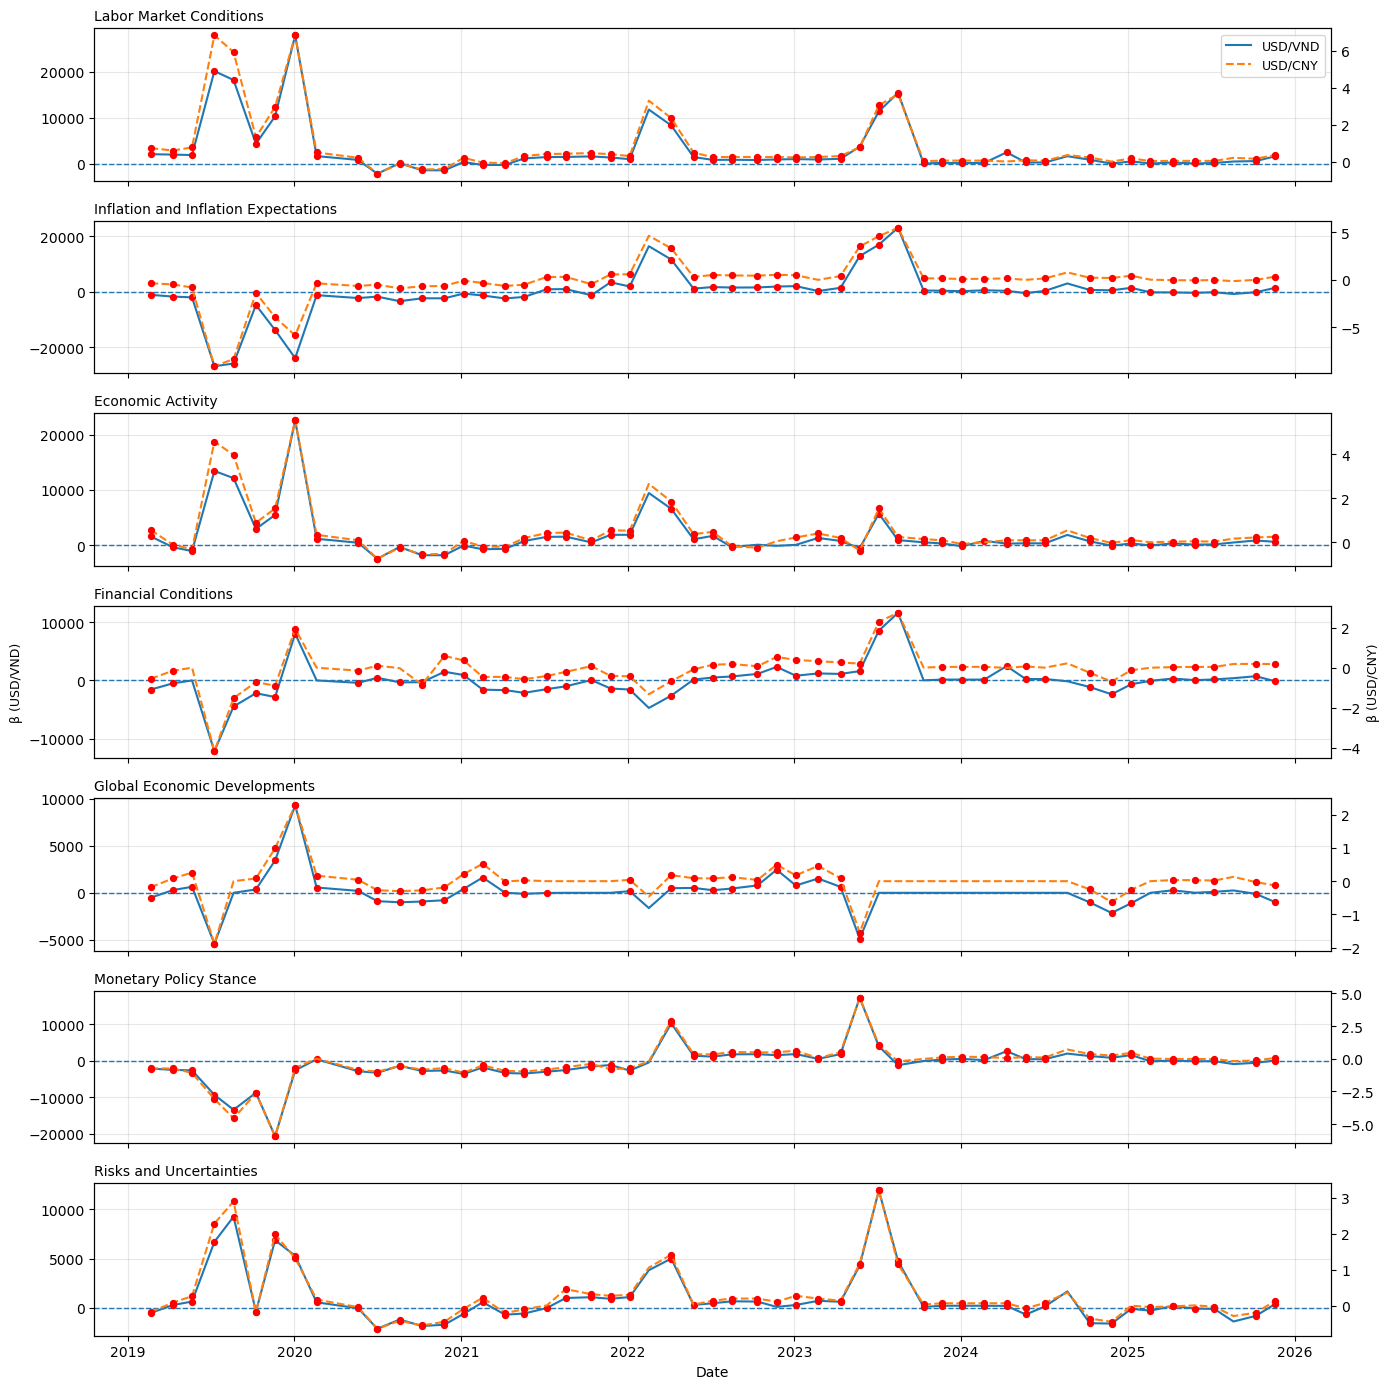

In [32]:
plot_fed_communication_figure(results_df_vnd, results_df_cny)

### Monetary Policy Stance as a Common Driver of USD/VND and USD/CNY

Compare the dynamics of the 'Monetary Policy Stance' beta across currencies using dual y-axes and significance markers.

In [33]:
def plot_monetary_policy_stance_common_driver(
    results_df_vnd: pd.DataFrame,
    results_df_cny: pd.DataFrame,
):
    """
    Figure: Monetary Policy Stance as the Common and Consistent Driver
    (Dual y-axis to compare dynamics of USD/VND and USD/CNY)
    """

    dates = pd.to_datetime(results_df_vnd["event_date"])

    beta_col = "beta_fomc_Monetary Policy Stance"
    sig_col = "significant_fomc_Monetary Policy Stance"

    beta_vnd = results_df_vnd[beta_col]
    beta_cny = results_df_cny[beta_col]

    sig_vnd = results_df_vnd[sig_col]
    sig_cny = results_df_cny[sig_col]

    fig, ax_left = plt.subplots(figsize=(10, 5))

    ax_left.plot(
        dates,
        beta_vnd,
        label="USD/VND",
        linewidth=2,
        markersize=3
    )

    ax_left.scatter(
        dates[sig_vnd],
        beta_vnd[sig_vnd],
        s=40,
        zorder=3,
        label="USD/VND significant"
    )

    ax_left.set_ylabel("β Monetary Policy Stance (USD/VND)")
    ax_left.axhline(0, linestyle="--", linewidth=1)
    ax_left.grid(True, alpha=0.3)

    ax_right = ax_left.twinx()

    ax_right.plot(
        dates,
        beta_cny,
        color='tab:orange',
        label="USD/CNY",
        linewidth=2,
        markersize=3,
    )

    ax_right.scatter(
        dates[sig_cny],
        beta_cny[sig_cny],
        color='tab:orange',
        s=40,
        zorder=3,
        label="USD/CNY significant"
    )

    ax_right.set_ylabel("β Monetary Policy Stance (USD/CNY)")

    ax_left.set_title(
        "Monetary Policy Stance as the Common and Consistent Driver",
        fontsize=13
    )
    ax_left.set_xlabel("Date")

    lines_l, labels_l = ax_left.get_legend_handles_labels()
    lines_r, labels_r = ax_right.get_legend_handles_labels()
    ax_left.legend(
        lines_l + lines_r,
        labels_l + labels_r,
        loc="upper left"
    )

    plt.tight_layout()
    plt.show()


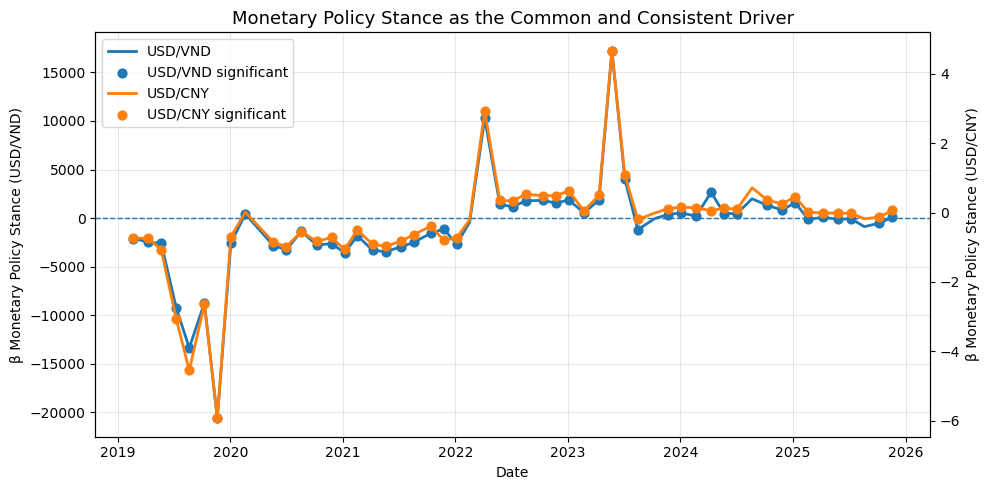

In [34]:
plot_monetary_policy_stance_common_driver(results_df_vnd, results_df_cny)

### Fed Communication Effects When Interest Rates Are Unchanged

Compare 'action' vs 'stance' betas across tightening and unchanged periods and highlight the periods where rate policy remained constant.

In [35]:
def plot_action_vs_stance_with_unchanged_periods(
    results_df_vnd: pd.DataFrame,
    results_df_cny: pd.DataFrame,
    tightening_periods: list,
):
    """
    Figure: Monetary Policy Stance replaces action when policy rates are left unchanged
    (Dual y-axis, journal-style colors)
    """

    dates = pd.to_datetime(results_df_vnd["event_date"])

    beta_action_vnd = results_df_vnd["beta_fed_funds_t"]
    beta_stance_vnd = results_df_vnd["beta_fomc_Monetary Policy Stance"]

    beta_action_cny = results_df_cny["beta_fed_funds_t"]
    beta_stance_cny = results_df_cny["beta_fomc_Monetary Policy Stance"]

    fig, ax_left = plt.subplots(figsize=(14, 4.5))

    for start, end in tightening_periods:
        color='gray'
        if start == '2022-02-01':
            color='red'
        ax_left.axvspan(
            pd.to_datetime(start),
            pd.to_datetime(end),
            color=color,
            alpha=0.18,
            zorder=0
        )

    ax_left.plot(
        dates, beta_action_vnd,
        color="tab:blue",
        linewidth=2,
        marker="o",
        markersize=4,
        label="β Fed action (USD/VND)"
    )

    ax_left.plot(
        dates, beta_stance_vnd,
        color="tab:orange",
        linewidth=2,
        marker="o",
        markersize=4,
        label="β Monetary Policy Stance (USD/VND)"
    )

    ax_left.axhline(0, color="black", linestyle="--", linewidth=1)
    ax_left.set_ylabel("β Monetary Policy Stance (USD/VND)")
    ax_left.grid(True, alpha=0.3)

    ax_right = ax_left.twinx()

    ax_right.plot(
        dates, beta_action_cny,
        color="tab:green",
        linestyle="--",
        linewidth=2,
        label="β Fed action (USD/CNY)"
    )

    ax_right.plot(
        dates, beta_stance_cny,
        color="tab:red",
        linestyle="--",
        linewidth=2,
        marker="o",
        markersize=4,
        label="β Monetary Policy Stance (USD/CNY)"
    )

    ax_right.set_ylabel("β Monetary Policy Stance (USD/CNY)")

    ax_left.set_title(
        "Monetary Policy Stance replaces action when policy rates are left unchanged",
        fontsize=12
    )
    ax_left.set_xlabel("Date")

    lines_l, labels_l = ax_left.get_legend_handles_labels()
    lines_r, labels_r = ax_right.get_legend_handles_labels()

    ax_left.legend(
        lines_l + lines_r,
        labels_l + labels_r,
        ncol=2,
        loc="lower right",
        frameon=True
    )

    plt.tight_layout()
    plt.show()


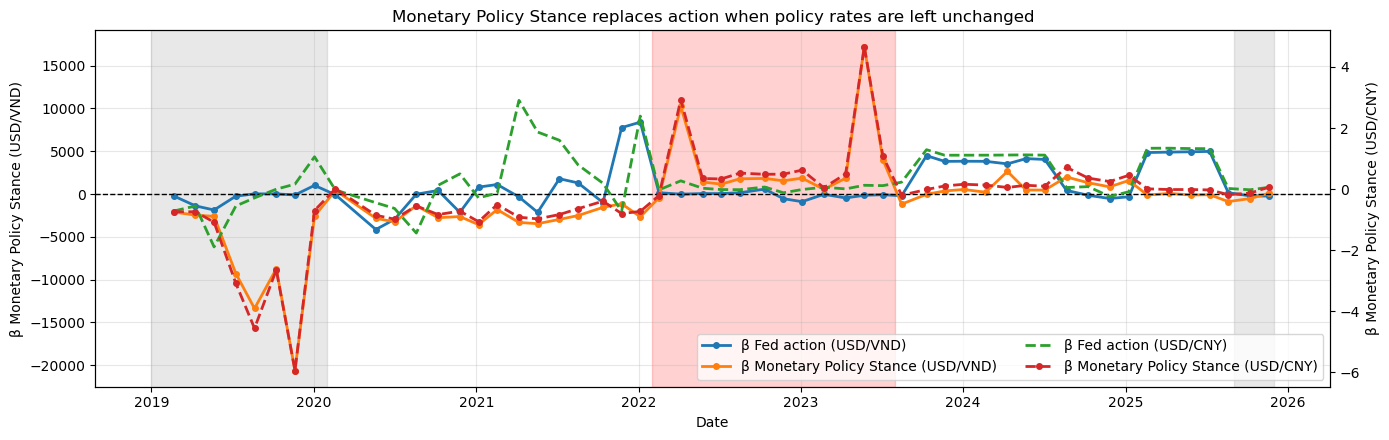

In [36]:
tightening_periods = [
    ("2019-01-01", "2020-02-01"),
    ("2022-02-01", "2023-08-01"),
    ("2025-09-01", "2025-12-01"),
]

plot_action_vs_stance_with_unchanged_periods(results_df_vnd, results_df_cny, tightening_periods)

### Robustness of the event study design

Robustness checks vary event window and event-date definitions (±10 / ±15 days; statement-day events).

Results are stable: Fed action affects USD/VND more than USD/CNY, and communication—especially Monetary Policy Stance—matters most when the policy rate is unchanged.

In [37]:
new_df = load_data()

##### Map significant events to their corresponding FOMC message labels.

In [38]:
def mapping_messages_to_significant_events(results_df: pd.DataFrame, df: pd.DataFrame) -> pd.DataFrame:
    """
    Map significant events to their corresponding FOMC message labels.

    Parameters
    ----------
    results_df_vnd : pd.DataFrame
        Rolling regression results containing `is_event_significant` and beta/p-value columns.
    df : pd.DataFrame
        Original dataset that includes the `fomc_change` label for each event.

    Returns
    -------
    pd.DataFrame
        DataFrame with `event_date`, `is_event_significant`, and the matched `fomc_change` for each event.
    """
    stats = count_significant_events(results_df)
    significant_event = results_df[['event_date', "is_event_significant"]]
    significant_event['fomc_change'] = df['fomc_change'].copy().dropna().values
    return significant_event

#### Alternative 1: +- 10 day

Shorter event window (±10 days) to test whether effects are concentrated close to the event date.

In [39]:
df_vnd_alter_1 = new_df.copy()

In [40]:
y_vars = ["Bid_FW_usd_vnd_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=10,
    days_after=10,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=df_vnd_alter_1,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_vnd = analyzer.rolling_event_regression_asymmetric()
summary_df_vnd = analyzer.summarize_results(results_df_vnd)
r_squared_mean = round(results_df_vnd['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_vnd)

R_Squared: 0.40506


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
1,fomc_Inflation and Inflation Expectations,47,54,0.870,-609.963848,0.001538,6841.293525,2019-08-21
7,fomc_action_dummy,47,54,0.870,6058.014880,0.000098,16047.248151,2019-08-21
6,fomc_Risks and Uncertainties,45,54,0.833,64.666629,0.000385,2810.063987,2019-11-20
0,fomc_Labor Market Conditions,44,54,0.815,770.492678,0.000600,4814.174445,2019-08-21
2,fomc_Economic Activity,43,54,0.796,350.977585,0.001008,3209.449630,2019-08-21
5,fomc_Monetary Policy Stance,43,54,0.796,-967.322139,0.000459,8806.517909,2019-10-09
3,fomc_Financial Conditions,42,54,0.778,-151.958572,0.000647,2199.653447,2019-10-09
4,fomc_Global Economic Developments,33,54,0.611,98.024765,0.000492,1621.922345,2021-02-17
8,fed_funds_t,33,54,0.611,3482.904638,0.000482,7943.382353,2025-11-19


In [41]:
significant_event_vnd = mapping_messages_to_significant_events(results_df_vnd, new_df)
significant_event_vnd[significant_event_vnd['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 49/54 significant events (90.74%)


,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,35


In [42]:
df_cny_alter_1 = new_df.copy()

In [43]:
y_vars = ["Bid_FW_usd_cny_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=10,
    days_after=10,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=df_cny_alter_1,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_cny = analyzer.rolling_event_regression_asymmetric()
summary_df_cny = analyzer.summarize_results(results_df_cny)
r_squared_mean = round(results_df_cny['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_cny)

R_Squared: 0.41399


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
7,fomc_action_dummy,47,54,0.870,1.812770,0.000573,7.251161,2025-11-19
0,fomc_Labor Market Conditions,46,54,0.852,0.185683,0.000870,1.362326,2019-10-09
5,fomc_Monetary Policy Stance,46,54,0.852,-0.267456,0.000517,2.724652,2019-10-09
1,fomc_Inflation and Inflation Expectations,45,54,0.833,-0.110967,0.000441,1.734150,2019-11-20
2,fomc_Economic Activity,43,54,0.796,0.088985,0.001221,0.908217,2019-10-09
6,fomc_Risks and Uncertainties,43,54,0.796,0.010837,0.000604,0.867075,2019-11-20
3,fomc_Financial Conditions,42,54,0.778,-0.072461,0.000406,0.751255,2020-10-07
4,fomc_Global Economic Developments,33,54,0.611,-0.000946,0.002211,0.474625,2021-02-17
8,fed_funds_t,33,54,0.611,1.070359,0.000821,3.878333,2020-01-03


In [44]:
significant_event_cny = mapping_messages_to_significant_events(results_df_cny, new_df)
significant_event_cny[significant_event_cny['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 49/54 significant events (90.74%)


,is_event_significant
fomc_change,
decrease,2
increase,10
maintain,37


In [45]:
beta_fed_funds_vnd = results_df_vnd['beta_fed_funds_t'] / results_df_vnd['beta_fed_funds_t'].abs().max()
beta_fed_funds_cny = results_df_cny['beta_fed_funds_t'] / results_df_cny['beta_fed_funds_t'].abs().max()
beta_fed_funds_vnd_cny = pd.DataFrame({
    "event_date": results_df_vnd['event_date'],
    "beta_fed_funds_vnd": beta_fed_funds_vnd,
    "beta_fed_funds_cny": beta_fed_funds_cny
    })

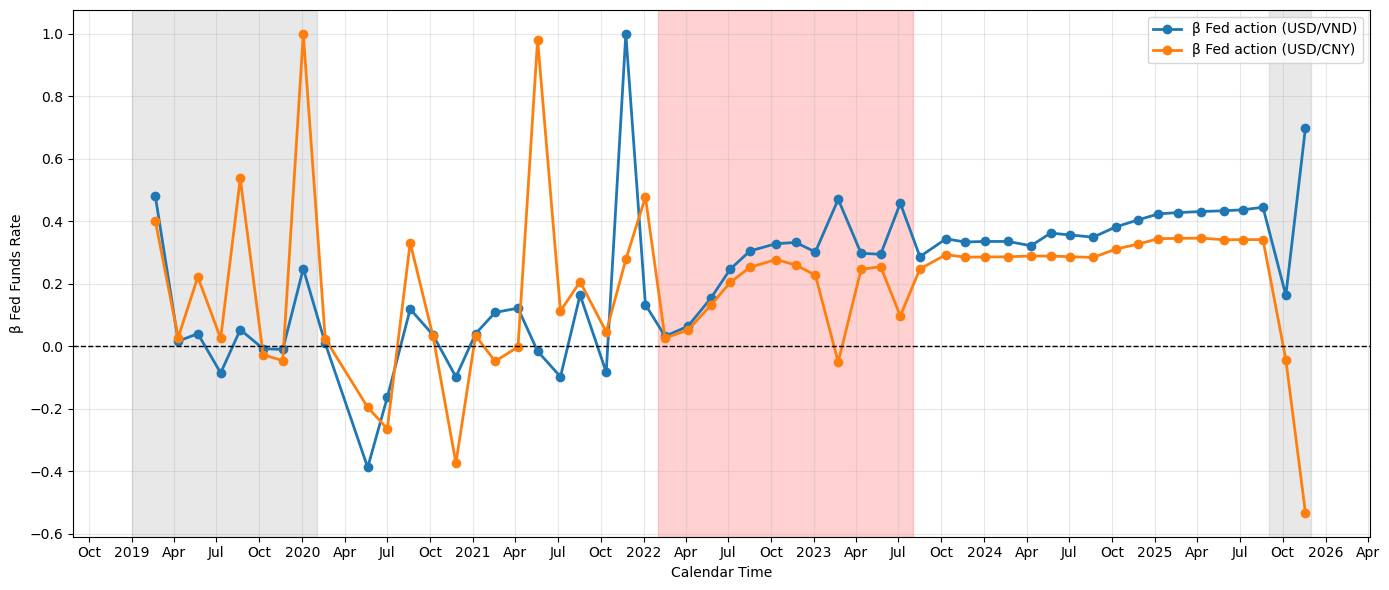

In [46]:
tightening_periods = [
    ("2019-01-01", "2020-02-01"),
    ("2022-02-01", "2023-08-01"),
    ("2025-09-01", "2025-12-01"),
]

plot_usdvnd_fed_action_with_tightening(
    df=beta_fed_funds_vnd_cny,
    tightening_periods=tightening_periods,
    beta_col= ['beta_fed_funds_vnd', 'beta_fed_funds_cny']
)

#### Alternative 2: +- 15 days

Moderately shorter window (±15 days) to check whether results are robust to a less generous event window.

In [47]:
df_vnd_alter_2 = new_df.copy()

In [48]:
y_vars = ["Bid_FW_usd_vnd_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=15,
    days_after=15,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=df_vnd_alter_2,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_vnd = analyzer.rolling_event_regression_asymmetric()
summary_df_vnd = analyzer.summarize_results(results_df_vnd)
r_squared_mean = round(results_df_vnd['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_vnd)

R_Squared: 0.45398


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
1,fomc_Inflation and Inflation Expectations,48,54,0.889,-869.324793,0.000573,28851.898699,2019-07-10
6,fomc_Risks and Uncertainties,47,54,0.870,399.021834,0.002331,7212.974675,2019-07-10
0,fomc_Labor Market Conditions,46,54,0.852,1566.015911,0.001757,21638.924024,2019-07-10
5,fomc_Monetary Policy Stance,46,54,0.852,-1111.265594,0.002448,20677.204345,2019-11-20
3,fomc_Financial Conditions,44,54,0.815,-520.836085,0.001738,13086.068000,2019-07-10
7,fomc_action_dummy,44,54,0.815,7261.469791,0.000504,17042.017700,2019-08-21
2,fomc_Economic Activity,42,54,0.778,872.618635,0.000472,14425.949349,2019-07-10
4,fomc_Global Economic Developments,31,54,0.574,-158.185944,0.001386,5873.093325,2019-07-10
8,fed_funds_t,23,54,0.426,2588.024823,0.003111,5463.113372,2019-02-20


In [49]:
significant_event_vnd = mapping_messages_to_significant_events(results_df_vnd, new_df)
significant_event_vnd[significant_event_vnd['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 50/54 significant events (92.59%)


,is_event_significant
fomc_change,
decrease,3
increase,8
maintain,39


In [50]:
df_cny_alter_2 = new_df.copy()

In [51]:
y_vars = ["Bid_FW_usd_cny_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=15,
    days_after=15,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=df_cny_alter_2,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_cny = analyzer.rolling_event_regression_asymmetric()
summary_df_cny = analyzer.summarize_results(results_df_cny)
r_squared_mean = round(results_df_cny['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_cny)

R_Squared: 0.45005


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
5,fomc_Monetary Policy Stance,50,54,0.926,-0.313253,0.001536,5.914359,2019-11-20
1,fomc_Inflation and Inflation Expectations,49,54,0.907,-0.254377,0.002602,8.301541,2019-07-10
0,fomc_Labor Market Conditions,48,54,0.889,0.432699,0.001891,6.226155,2019-07-10
2,fomc_Economic Activity,48,54,0.889,0.210405,0.001803,4.150770,2019-07-10
7,fomc_action_dummy,48,54,0.889,2.141256,0.001727,5.951691,2019-08-21
6,fomc_Risks and Uncertainties,46,54,0.852,0.112662,0.001145,2.075385,2019-07-10
3,fomc_Financial Conditions,44,54,0.815,-0.178297,0.002688,3.804545,2019-07-10
4,fomc_Global Economic Developments,34,54,0.630,-0.061504,0.003341,1.729159,2019-07-10
8,fed_funds_t,24,54,0.444,0.715995,0.004320,2.312250,2020-01-03


In [52]:
significant_event_cny = mapping_messages_to_significant_events(results_df_cny, new_df)
significant_event_cny[significant_event_cny['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 53/54 significant events (98.15%)


,is_event_significant
fomc_change,
decrease,3
increase,10
maintain,40


In [53]:
beta_fed_funds_vnd = results_df_vnd['beta_fed_funds_t'] / results_df_vnd['beta_fed_funds_t'].abs().max()
beta_fed_funds_cny = results_df_cny['beta_fed_funds_t'] / results_df_cny['beta_fed_funds_t'].abs().max()
beta_fed_funds_vnd_cny = pd.DataFrame({
    "event_date": results_df_vnd['event_date'],
    "beta_fed_funds_vnd": beta_fed_funds_vnd,
    "beta_fed_funds_cny": beta_fed_funds_cny
    })

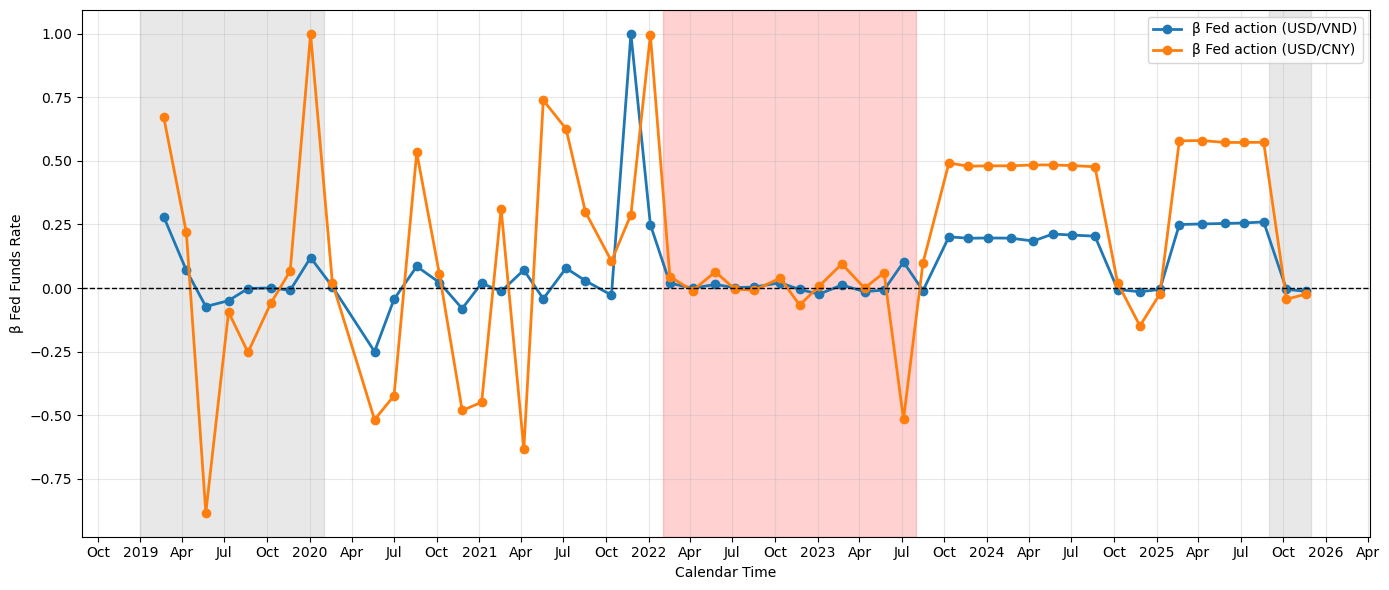

In [54]:
tightening_periods = [
    ("2019-01-01", "2020-02-01"),
    ("2022-02-01", "2023-08-01"),
    ("2025-09-01", "2025-12-01"),
]

plot_usdvnd_fed_action_with_tightening(
    df=beta_fed_funds_vnd_cny,
    tightening_periods=tightening_periods,
    beta_col= ['beta_fed_funds_vnd', 'beta_fed_funds_cny']
)

#### Alternative 3: Statement-day events

Restrict to statement-day events to isolate immediate communication effects tied to official statements.

In [55]:
new_df['fomc_event_statement'] = new_df['fomc_Labor Market Conditions'].notna().astype(int)

In [56]:
df_vnd_alter_3 = new_df.copy()

In [57]:
y_vars = ["Bid_FW_usd_vnd_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=21,
    days_after=21,
    event_col="fomc_event_statement"  # dummy statement event
)

analyzer = EventRolling(
    df=df_vnd_alter_3,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_vnd = analyzer.rolling_event_regression_asymmetric()
summary_df_vnd = analyzer.summarize_results(results_df_vnd)
r_squared_mean = round(results_df_vnd['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_vnd)

R_Squared: 0.52237


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,51,54,0.944,2908.572580,0.000456,27894.766090,2020-01-03
1,fomc_Inflation and Inflation Expectations,51,54,0.944,-600.705494,0.000023,26832.919377,2019-07-10
5,fomc_Monetary Policy Stance,50,54,0.926,-947.376870,0.000008,20632.297277,2019-11-20
6,fomc_Risks and Uncertainties,50,54,0.926,1015.752831,0.000073,11943.676103,2023-07-05
2,fomc_Economic Activity,48,54,0.889,1659.308401,0.000019,22599.724408,2020-01-03
3,fomc_Financial Conditions,48,54,0.889,54.314077,0.001091,12122.411914,2019-07-10
7,fomc_action_dummy,47,54,0.870,7160.647777,0.001129,14564.350919,2019-10-09
4,fomc_Global Economic Developments,36,54,0.667,150.819133,0.000054,9298.255363,2020-01-03
8,fed_funds_t,31,54,0.574,1142.848486,0.002264,4977.672762,2025-07-09


In [58]:
significant_event_vnd = mapping_messages_to_significant_events(results_df_vnd, new_df)
significant_event_vnd[significant_event_vnd['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 51/54 significant events (94.44%)


,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,37


In [59]:
df_cny_alter_3 = new_df.copy()

In [60]:
y_vars = ["Bid_FW_usd_cny_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
    "fomc_action_dummy"
]

config = EventRollingConfig(
    lags=list(range(0, 1)), # no lag
    days_before=21,
    days_after=21,
    event_col="fomc_event_statement"  # dummy statement event
)

analyzer = EventRolling(
    df=df_cny_alter_3,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_cny = analyzer.rolling_event_regression_asymmetric()
summary_df_cny = analyzer.summarize_results(results_df_cny)
r_squared_mean = round(results_df_cny['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_cny)

R_Squared: 0.47696


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,49,54,0.907,0.842743,9.429569e-06,6.850188,2019-07-10
5,fomc_Monetary Policy Stance,49,54,0.907,-0.343727,1.086958e-03,5.937686,2019-11-20
1,fomc_Inflation and Inflation Expectations,48,54,0.889,-0.275465,4.039844e-07,9.133585,2019-07-10
2,fomc_Economic Activity,48,54,0.889,0.465734,1.164666e-06,5.532140,2020-01-03
6,fomc_Risks and Uncertainties,47,54,0.870,0.321106,1.806727e-04,3.208248,2023-07-05
7,fomc_action_dummy,46,54,0.852,2.109332,5.345585e-06,5.170886,2019-05-22
3,fomc_Financial Conditions,44,54,0.815,-0.065850,1.439787e-04,4.166679,2019-07-10
4,fomc_Global Economic Developments,36,54,0.667,0.015905,4.824290e-04,2.282846,2020-01-03
8,fed_funds_t,26,54,0.481,0.653291,3.337185e-03,2.906688,2021-04-07


In [61]:
significant_event_cny = mapping_messages_to_significant_events(results_df_cny, new_df)
significant_event_cny[significant_event_cny['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 51/54 significant events (94.44%)


,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,37


In [62]:
beta_fed_funds_vnd = results_df_vnd['beta_fed_funds_t'] / results_df_vnd['beta_fed_funds_t'].abs().max()
beta_fed_funds_cny = results_df_cny['beta_fed_funds_t'] / results_df_cny['beta_fed_funds_t'].abs().max()
beta_fed_funds_vnd_cny = pd.DataFrame({
    "event_date": results_df_vnd['event_date'],
    "beta_fed_funds_vnd": beta_fed_funds_vnd,
    "beta_fed_funds_cny": beta_fed_funds_cny
    })

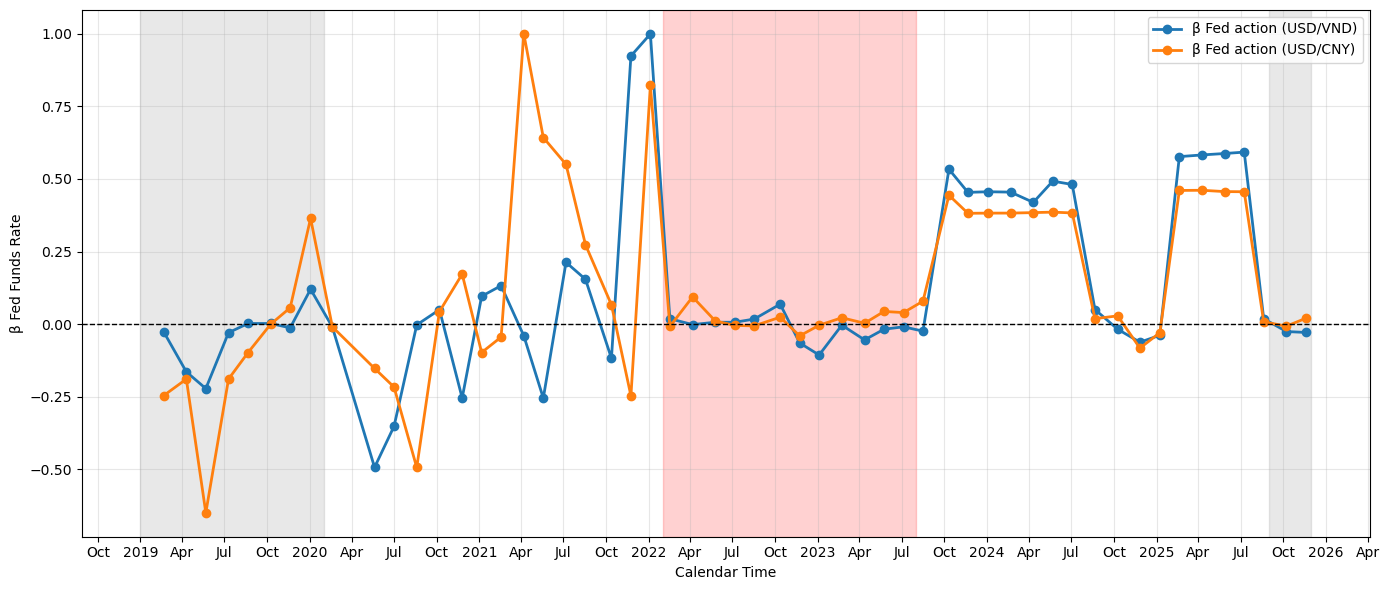

In [63]:
tightening_periods = [
    ("2019-01-01", "2020-02-01"),
    ("2022-02-01", "2023-08-01"),
    ("2025-09-01", "2025-12-01"),
]

plot_usdvnd_fed_action_with_tightening(
    df=beta_fed_funds_vnd_cny,
    tightening_periods=tightening_periods,
    beta_col= ['beta_fed_funds_vnd', 'beta_fed_funds_cny']
)

#### Alternative 4: Minutes-only events

Run regressions on minutes-only events and exclude FOMC statement message variables to isolate communication effects absent statement messages.

In [64]:
df_vnd_alter_4 = new_df.copy()

In [65]:
y_vars = ["Bid_FW_usd_vnd_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties"
]

config = EventRollingConfig(
    lags=list(range(0, 1)),
    days_before=21,
    days_after=21,
    event_col="fomc_event" 
)

analyzer = EventRolling(
    df=df_vnd_alter_4,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_vnd = analyzer.rolling_event_regression_asymmetric()
summary_df_vnd = analyzer.summarize_results(results_df_vnd)
r_squared_mean = round(results_df_vnd['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_vnd)

R_Squared: 0.51069


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,51,54,0.944,9503.697364,2.144405e-04,50458.110840,2025-11-19
1,fomc_Inflation and Inflation Expectations,51,54,0.944,-344.566494,1.346296e-06,43982.689899,2025-11-19
2,fomc_Economic Activity,51,54,0.944,4829.026363,2.202686e-05,61123.794716,2025-10-08
6,fomc_Risks and Uncertainties,51,54,0.944,-25.381898,2.147278e-04,59980.920430,2025-10-08
5,fomc_Monetary Policy Stance,50,54,0.926,-4137.580376,5.571147e-05,42987.269953,2025-01-08
3,fomc_Financial Conditions,48,54,0.889,-690.217621,4.589109e-07,53721.419186,2025-10-08
4,fomc_Global Economic Developments,38,54,0.704,-1098.214351,4.840075e-04,26952.125093,2024-11-26
7,fed_funds_t,33,54,0.611,1333.821882,2.801326e-03,6034.848338,2025-07-09


In [66]:
significant_event_vnd = mapping_messages_to_significant_events(results_df_vnd, new_df)
significant_event_vnd[significant_event_vnd['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 52/54 significant events (96.30%)


,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,38


In [67]:
df_cny_alter_4 = new_df.copy()

In [68]:
y_vars = ["Bid_FW_usd_cny_1y"]

lagged_indep_vars = [
    "fed_funds"
]

event_vars = [
    "fomc_Labor Market Conditions",
    "fomc_Inflation and Inflation Expectations",
    "fomc_Economic Activity",
    "fomc_Financial Conditions",
    "fomc_Global Economic Developments",
    "fomc_Monetary Policy Stance",
    "fomc_Risks and Uncertainties",
]

config = EventRollingConfig(
    lags=list(range(0, 1)),
    days_before=21,
    days_after=21,
    event_col="fomc_event"  # dummy event
)

analyzer = EventRolling(
    df=df_cny_alter_4,
    x_lagged_vars=lagged_indep_vars,
    x_non_lagged_vars=event_vars,
    y_vars=y_vars,
    config=config
)

results_df_cny = analyzer.rolling_event_regression_asymmetric()
summary_df_cny = analyzer.summarize_results(results_df_cny)
r_squared_mean = round(results_df_cny['r_squared'].mean(), 5)
print(f'R_Squared: {r_squared_mean}')
display(summary_df_cny)

R_Squared: 0.46311


,variable,significant_count,total_events,significant_ratio,mean_beta,mean_pval,max_abs_beta,max_beta_date
0,fomc_Labor Market Conditions,50,54,0.926,2.747590,1.192752e-08,12.077775,2025-11-19
5,fomc_Monetary Policy Stance,50,54,0.926,-1.388728,1.251136e-04,11.916563,2025-01-08
6,fomc_Risks and Uncertainties,50,54,0.926,0.064188,2.593027e-06,15.330214,2025-10-08
1,fomc_Inflation and Inflation Expectations,49,54,0.907,-0.334709,1.082298e-08,11.013822,2025-01-08
2,fomc_Economic Activity,49,54,0.907,1.349730,2.143361e-07,15.635366,2025-10-08
3,fomc_Financial Conditions,45,54,0.833,-0.340910,5.022826e-08,13.744519,2025-10-08
4,fomc_Global Economic Developments,38,54,0.704,-0.290317,4.756935e-04,7.863054,2024-11-26
7,fed_funds_t,27,54,0.500,0.681000,1.900157e-03,2.906688,2021-04-07


In [69]:
significant_event_cny = mapping_messages_to_significant_events(results_df_cny, new_df)
significant_event_cny[significant_event_cny['is_event_significant']].groupby('fomc_change').count()[['is_event_significant']]

There are 52/54 significant events (96.30%)


,is_event_significant
fomc_change,
decrease,3
increase,11
maintain,38


In [70]:
beta_fed_funds_vnd = results_df_vnd['beta_fed_funds_t'] / results_df_vnd['beta_fed_funds_t'].abs().max()
beta_fed_funds_cny = results_df_cny['beta_fed_funds_t'] / results_df_cny['beta_fed_funds_t'].abs().max()
beta_fed_funds_vnd_cny = pd.DataFrame({
    "event_date": results_df_vnd['event_date'],
    "beta_fed_funds_vnd": beta_fed_funds_vnd,
    "beta_fed_funds_cny": beta_fed_funds_cny
    })

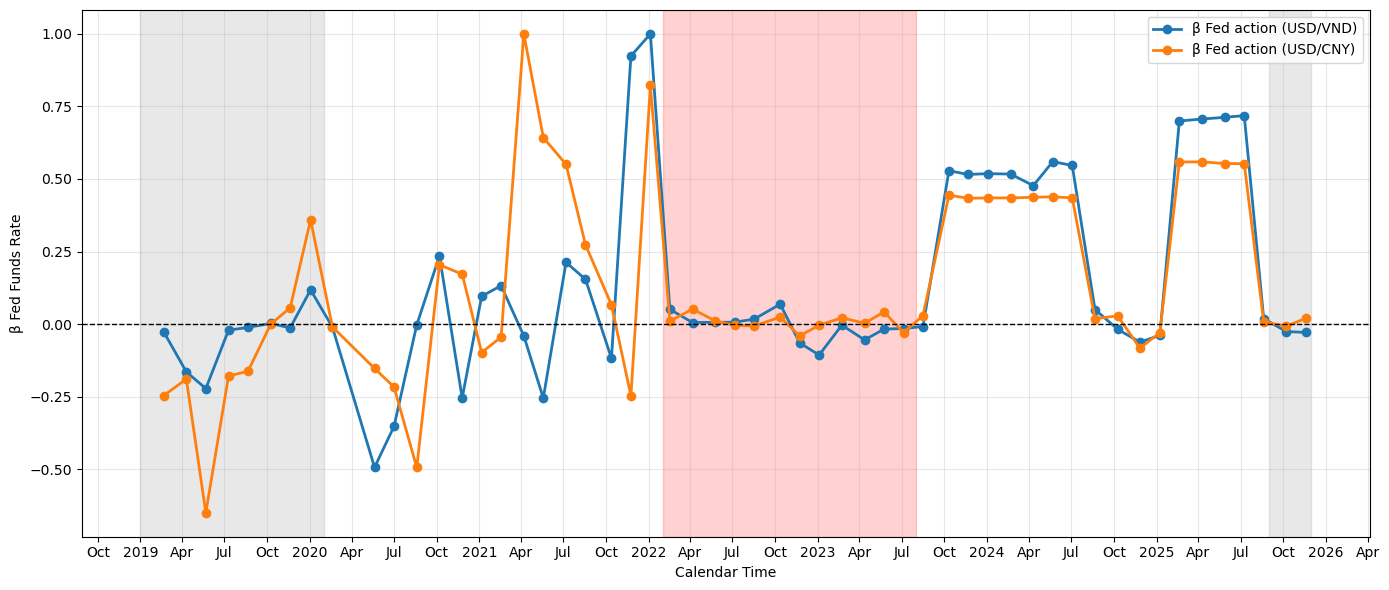

In [71]:
tightening_periods = [
    ("2019-01-01", "2020-02-01"),
    ("2022-02-01", "2023-08-01"),
    ("2025-09-01", "2025-12-01"),
]

plot_usdvnd_fed_action_with_tightening(
    df=beta_fed_funds_vnd_cny,
    tightening_periods=tightening_periods,
    beta_col= ['beta_fed_funds_vnd', 'beta_fed_funds_cny']
)